<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/inference_vs_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Inference vs measurement comparison

This Colab notebook loads model inference CSV files and matching measurement CSV files, plots predictions versus actual temperatures, and computes an approximate mean absolute error (MAE) over the overlapping time range. It is designed to be flexible so future inference and measurement files can be compared without code changes.


## Requirements

- Place inference and measurement CSV files in a `measurements/` folder relative to the notebook (for Colab, clone or upload this repository first).
- Inference files follow the pattern `inference_YYYY-MM-DD.csv` with columns `timestamp_iso8601` and `predicted_temperature_c` (or other `predicted_temperature_c_plus_*` horizons). If present, an `inference_time_ms` column will be graphed.
- Measurement files follow the pattern `measurements_YYYY-MM-DD.csv` with columns `timestamp_iso8601`, `sensor`, `quantity`, `value`, and `unit`.
- The notebook filters to the `bme280` sensor and `temperature_c` quantity by default; adjust these if your data uses different labels.

In [73]:

# Install dependencies (uncomment if running outside of Colab where pandas/matplotlib are missing)
# %pip install pandas matplotlib


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from datetime import timedelta

pd.set_option("display.max_rows", 10)

# Path to the measurements directory. Update this if your data lives elsewhere.
DATA_DIR = pathlib.Path("../measurements") if pathlib.Path("../measurements").exists() else pathlib.Path("measurements")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Could not find measurements directory at {DATA_DIR.resolve()}")

print(f"Using data directory: {DATA_DIR.resolve()}")

Using data directory: /content/measurements


In [75]:
# Discover available inference and measurement files
inference_files = sorted(DATA_DIR.glob("inference_*.csv"))
measurement_files = sorted(DATA_DIR.glob("measurements_*.csv"))

if not inference_files:
    raise FileNotFoundError("No inference files found.")
if not measurement_files:
    raise FileNotFoundError("No measurement files found.")

print("Available inference files (dates):")
for path in inference_files:
    print(f"- {path.name}")

print("Available measurement files (dates):")
for path in measurement_files:
    print(f"- {path.name}")

Available inference files (dates):
- inference_2025-12-06.csv
- inference_2025-12-07.csv
- inference_2025-12-11.csv
- inference_2025-12-12.csv
- inference_2025-12-13.csv
- inference_2025-12-14.csv
- inference_2025-12-15.csv
- inference_2025-12-16.csv
Available measurement files (dates):
- measurements_2025-12-06.csv
- measurements_2025-12-07.csv
- measurements_2025-12-11.csv
- measurements_2025-12-12.csv
- measurements_2025-12-13.csv
- measurements_2025-12-14.csv
- measurements_2025-12-15.csv
- measurements_2025-12-16.csv


## Configuration

You can analyze one or multiple days at once by providing lists of inference and measurement filenames. If measurement filenames are omitted, the notebook will attempt to match them by date from the selected inference files. You can also adjust the sensor/quantity filters and the time tolerance used when aligning predictions to measurements.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from datetime import timedelta

pd.set_option("display.max_rows", 10)

# Provide explicit filenames (e.g., ["inference_2025-11-07.csv", "inference_2025-11-08.csv"]).
# Leave empty to analyze the latest inference file discovered above.
INFERENCE_FILENAMES = ["inference_2025-12-11.csv","inference_2025-12-12.csv","inference_2025-12-13.csv"]

# Provide explicit measurement filenames. Leave empty to automatically match the dates of the inference filenames.
MEASUREMENT_FILENAMES = ["measurements_2025-12-11.csv","measurements_2025-12-12.csv","measurements_2025-12-13.csv"]

TARGET_SENSOR = "bme280"
TARGET_QUANTITY = "temperature_c"
MERGE_TOLERANCE_MINUTES = 15  # Maximum time difference (minutes) when pairing prediction/measurement rows.
PREFERRED_PREDICTION_COLUMN = "predicted_temperature_c_plus_01h00m"  # Fallback horizon to use when renaming.

# Optional: Set start and stop datetimes for plotting. Leave as None to plot all available data.
START_DATETIME_STR = "2025-12-11 12:00:00+00:00" # e.g., "2025-12-11 06:00:00+00:00"
STOP_DATETIME_STR = "2025-12-13 12:00:00+00:00"  # e.g., "2025-12-12 18:00:00+00:00"

def extract_date_fragment(name: str, prefix: str) -> str:
    if not name.startswith(prefix) or not name.endswith(".csv"):
        return ""
    return name.replace(prefix, "").replace(".csv", "")


# Build lists of selected inference and measurement files
if INFERENCE_FILENAMES:
    selected_inference_paths = [DATA_DIR / name for name in INFERENCE_FILENAMES]
else:
    selected_inference_paths = [inference_files[-1]]  # latest by filename sort

selected_measurement_paths = []
if MEASUREMENT_FILENAMES:
    selected_measurement_paths = [DATA_DIR / name for name in MEASUREMENT_FILENAMES]
else:
    for inference_path in selected_inference_paths:
        date_fragment = extract_date_fragment(inference_path.name, "inference_")
        candidate = DATA_DIR / f"measurements_{date_fragment}.csv"
        if candidate.exists():
            selected_measurement_paths.append(candidate)
    # Deduplicate while preserving order
    seen = set()
    deduped = []
    for path in selected_measurement_paths:
        if path.name not in seen:
            deduped.append(path)
            seen.add(path.name)
    selected_measurement_paths = deduped

if not selected_measurement_paths:
    raise FileNotFoundError("Could not find matching measurement files. Set MEASUREMENT_FILENAMES explicitly.")

print("Selected inference files:")
for path in selected_inference_paths:
    print(f"- {path.name}")

print("Selected measurement files:")
for path in selected_measurement_paths:
    print(f"- {path.name}")


Selected inference files:
- inference_2025-12-11.csv
- inference_2025-12-12.csv
- inference_2025-12-13.csv
Selected measurement files:
- measurements_2025-12-11.csv
- measurements_2025-12-12.csv
- measurements_2025-12-13.csv


In [77]:
# Helpers

def ensure_prediction_column(df: pd.DataFrame) -> pd.DataFrame:
    if "predicted_temperature_c" in df.columns:
        return df
    if PREFERRED_PREDICTION_COLUMN in df.columns:
        return df.rename(columns={PREFERRED_PREDICTION_COLUMN: "predicted_temperature_c"})
    fallback = next((col for col in df.columns if col.startswith("predicted_temperature_c_plus_")), None)
    if fallback:
        print(f"Using {fallback} as 'predicted_temperature_c'.")
        return df.rename(columns={fallback: "predicted_temperature_c"})
    raise ValueError("No prediction column found in the inference data.")


# Load inference data
inference_frames = []
for path in selected_inference_paths:
    df = pd.read_csv(path, parse_dates=["timestamp_iso8601"])
    if df.empty:
        raise ValueError(f"Inference file {path.name} has no rows.")
    df = df.sort_values("timestamp_iso8601").rename(columns={"timestamp_iso8601": "timestamp"})
    df = ensure_prediction_column(df)
    df["source_file"] = path.name

    retained_columns = ["timestamp", "predicted_temperature_c", "source_file"]
    if "inference_time_ms" in df.columns:
        retained_columns.append("inference_time_ms")
    inference_frames.append(df[retained_columns])

inference_df = pd.concat(inference_frames, ignore_index=True).sort_values("timestamp")

# Load measurement data and filter to the target sensor/quantity
measurement_frames = []
for path in selected_measurement_paths:
    raw = pd.read_csv(path, parse_dates=["timestamp_iso8601"])
    filtered = raw[
        (raw["sensor"] == TARGET_SENSOR)
        & (raw["quantity"] == TARGET_QUANTITY)
    ].copy()
    if filtered.empty:
        raise ValueError(
            f"No measurements found for sensor '{TARGET_SENSOR}' and quantity '{TARGET_QUANTITY}' in {path.name}."
        )
    filtered = filtered.sort_values("timestamp_iso8601").rename(
        columns={"timestamp_iso8601": "timestamp", "value": "measured_temperature_c"}
    )
    filtered["source_file"] = path.name
    measurement_frames.append(filtered[["timestamp", "measured_temperature_c", "source_file"]])

measurements_df = pd.concat(measurement_frames, ignore_index=True).sort_values("timestamp")

print(inference_df.head())
print(measurements_df.head())

                  timestamp  predicted_temperature_c  \
0 2025-12-11 00:04:39+00:00                25.534132   
1 2025-12-11 00:09:37+00:00                25.534132   
2 2025-12-11 00:14:34+00:00                25.534132   
3 2025-12-11 00:19:32+00:00                25.534132   
4 2025-12-11 00:24:30+00:00                25.534132   

                source_file  inference_time_ms  
0  inference_2025-12-11.csv                135  
1  inference_2025-12-11.csv                135  
2  inference_2025-12-11.csv                135  
3  inference_2025-12-11.csv                135  
4  inference_2025-12-11.csv                135  
                  timestamp  measured_temperature_c  \
0 2025-12-11 00:00:09+00:00               27.555122   
1 2025-12-11 00:00:19+00:00               27.550079   
2 2025-12-11 00:00:39+00:00               27.550079   
3 2025-12-11 00:00:49+00:00               27.539993   
4 2025-12-11 00:00:59+00:00               27.550079   

                   source_file  
0  me

In [78]:
# Align predictions with the nearest measurement within the tolerance window
merge_tolerance = pd.Timedelta(minutes=MERGE_TOLERANCE_MINUTES)
aligned_df = pd.merge_asof(
    inference_df,
    measurements_df[["timestamp", "measured_temperature_c"]],
    on="timestamp",
    direction="nearest",
    tolerance=merge_tolerance,
)

aligned_df = aligned_df.dropna(subset=["measured_temperature_c"])
if aligned_df.empty:
    raise ValueError(
        "No overlapping prediction/measurement pairs were found within the tolerance window. "
        "Try increasing MERGE_TOLERANCE_MINUTES or verifying the file selection."
    )

aligned_df["absolute_error"] = (aligned_df["predicted_temperature_c"] - aligned_df["measured_temperature_c"]).abs()
mae = aligned_df["absolute_error"].mean()

print(f"Paired rows: {len(aligned_df)}")
print(f"Approximate MAE: {mae:.3f} °C")

Paired rows: 863
Approximate MAE: 2.142 °C


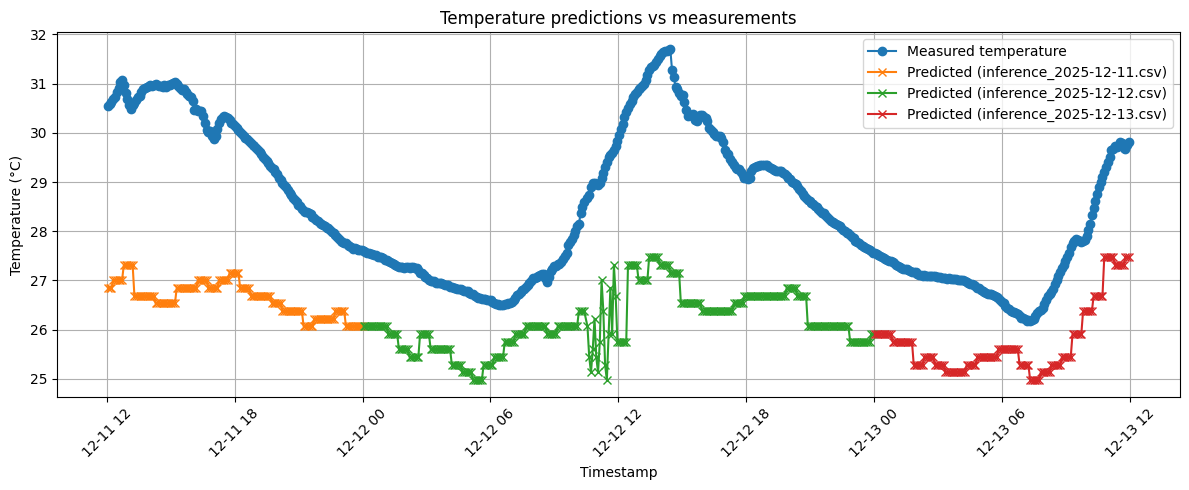

In [79]:
# Plot predictions vs. measurements over time

plot_df = aligned_df.copy()
if START_DATETIME_STR:
    plot_df = plot_df[plot_df["timestamp"] >= pd.to_datetime(START_DATETIME_STR)]
if STOP_DATETIME_STR:
    plot_df = plot_df[plot_df["timestamp"] <= pd.to_datetime(STOP_DATETIME_STR)]

plt.figure(figsize=(12, 5))
plt.plot(plot_df["timestamp"], plot_df["measured_temperature_c"], label="Measured temperature", marker="o")
for source, group in plot_df.groupby("source_file"):
    plt.plot(group["timestamp"], group["predicted_temperature_c"], label=f"Predicted ({source})", marker="x")
plt.title("Temperature predictions vs measurements")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

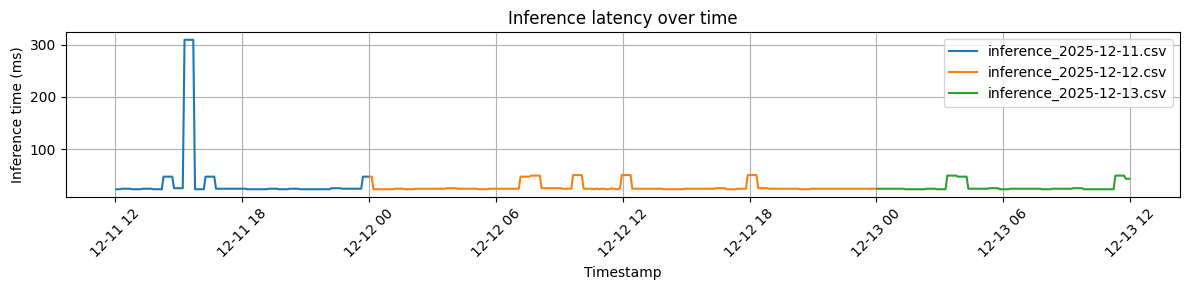

In [80]:
# Plot inference time when available

plot_inference_df = inference_df.copy()
if START_DATETIME_STR:
    plot_inference_df = plot_inference_df[plot_inference_df["timestamp"] >= pd.to_datetime(START_DATETIME_STR)]
if STOP_DATETIME_STR:
    plot_inference_df = plot_inference_df[plot_inference_df["timestamp"] <= pd.to_datetime(STOP_DATETIME_STR)]

if "inference_time_ms" in inference_df.columns:
    plt.figure(figsize=(12, 3))
    for source, group in plot_inference_df.groupby("source_file"):
        plt.plot(group["timestamp"], group["inference_time_ms"], label=source)
    plt.title("Inference latency over time")
    plt.xlabel("Timestamp")
    plt.ylabel("Inference time (ms)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("No inference_time_ms column found; skipping inference time plot.")

## Error visualization

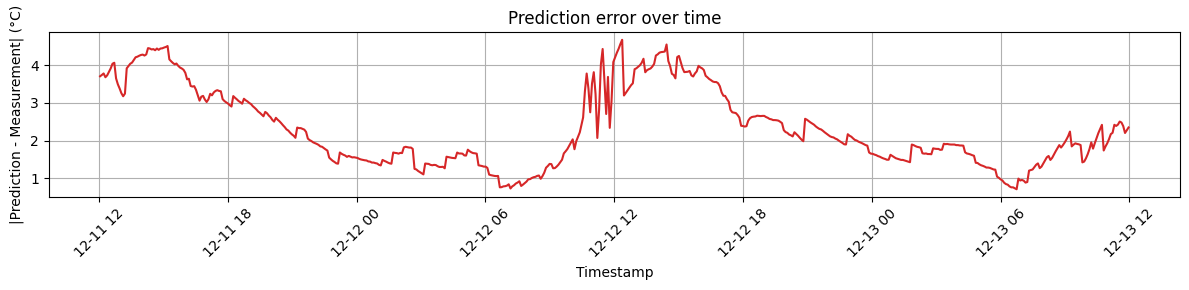

In [81]:
# Optional: visualize the absolute error over time

plot_df = aligned_df.copy()
if START_DATETIME_STR:
    plot_df = plot_df[plot_df["timestamp"] >= pd.to_datetime(START_DATETIME_STR)]
if STOP_DATETIME_STR:
    plot_df = plot_df[plot_df["timestamp"] <= pd.to_datetime(STOP_DATETIME_STR)]

plt.figure(figsize=(12, 3))
plt.plot(plot_df["timestamp"], plot_df["absolute_error"], label="Absolute error", color="tab:red")
plt.title("Prediction error over time")
plt.xlabel("Timestamp")
plt.ylabel("|Prediction - Measurement| (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Saving aligned data (optional)

Uncomment the cell below to save the aligned predictions, measurements, and error values for further analysis.


In [82]:
# summary_name = "+".join(path.stem for path in selected_inference_paths)
# output_path = DATA_DIR / f"aligned_{summary_name}.csv"
# aligned_df.to_csv(output_path, index=False)
# print(f"Saved aligned data to {output_path}")